<a href="https://colab.research.google.com/github/TYH71/DELE_CA1/blob/main/Part%20A/3.2%20ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 - ResNet


- Name: Tan Yu Hoe
- Admin No: P2026309
- Class: DAAA/FT/2B/04

## Motivation

This notebook is purposed to train and evaluate a Convolution Neural Network on CIFAR-10 dataset, implementing a ResNetv1 architecture without transfer learning. The goal is to achieve high validation accuracy with a smaller ResNet network.

## Personal Objectives

These are objectives / goals for myself to accomplish while attempting to perform image classification for the CIFAR-10 dataset.

1. Obtain a high test accuracy compared to public benchmark (The average benchmark for CIFAR-10 is about 85% Test Accuracy)
2. Experiment with multiple training strategies and CNN architectures

## !! Important Note !!

As this is an experimentation run, I would not go so in depth into Exploratory Data Analysis, Feature Engineering, Augmentation and Image Processing. The markdown headers are used as checkpoints for me to better navigate around the notebook using Google Colaboratory.



In [1]:
# import relevant libraries/classes/dependencies
import os
import random

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
import datetime
!pip install -q pytz
import pytz
sg = pytz.timezone("Singapore")

# Set the random seeds - to ensure reproducibility
os.environ['TF_CUDNN_DETERMINISTIC'] = "1"
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
# Matplotlib Stylings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.autolayout'] = True
plt.style.use('fivethirtyeight')

## Setting up **Weights and Biases**


In [3]:
# install and configure weights and biases
!pip install -q wandb
import wandb
from wandb.keras import WandbCallback
wandb.login()

wandb: Currently logged in as: tyh71 (use `wandb login --relogin` to force relogin)


True

## Training on a Tesla P100-PCIE-16GB


In [4]:
# Checking if GPU is available
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2461085888585093720
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16154099712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1538099608156404017
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


## Data Injestion

In [5]:
# Import Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', "Coat", "Sandle", 'Shirt', 'Sneaker', 'Bag', 'Ankle Boots']
print('Dataset Loaded')

Dataset Loaded


In [6]:
# Shape of Training and Testing Sets
print("X_train:", x_train.shape, "y_train:", y_train.shape)
print("X_test:", x_test.shape, "y_test:", y_test.shape)

X_train: (60000, 28, 28) y_train: (60000,)
X_test: (10000, 28, 28) y_test: (10000,)


In [7]:
# Import Keras Functions
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import plot_model
from tensorflow.nn import local_response_normalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

## Feature Engineering


In [8]:
def preprocessing_func(x, y):
    # preprocess X
    x = x.reshape((-1, 28, 28, 1))
    x = tf.cast(x, tf.float32)
    x = tf.image.grayscale_to_rgb(x)
    x = ZeroPadding2D(padding=(2, 2))(x)
    x = Rescaling(1./127.5, offset=-1)(x)

    return x, y

# transform 
x_train, y_train = preprocessing_func(x_train, y_train)
x_test, y_test = preprocessing_func(x_test, y_test)

print("Training Shape:", x_train.shape, y_train.shape)
print("Testing Shape:", x_test.shape, y_test.shape)

Training Shape: (60000, 32, 32, 3) (60000,)
Testing Shape: (10000, 32, 32, 3) (10000,)


## Data Augmentation


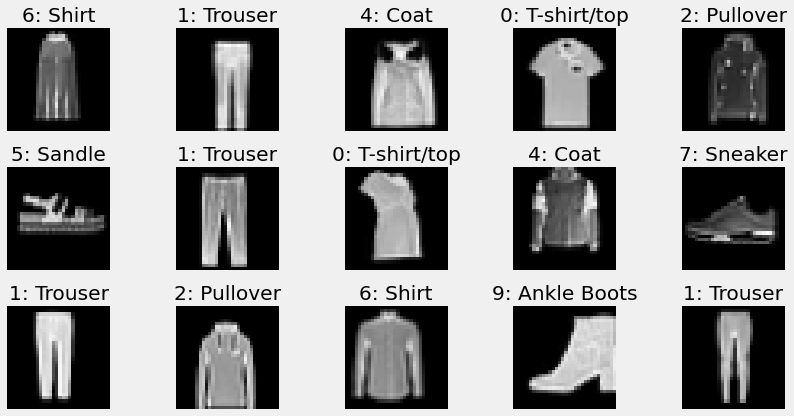

In [9]:
## source code: https://github.com/yu4u/mixup-generator/blob/master/random_eraser.py
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255):
    def eraser(input_img):
        img_h, img_w, _ = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        c = np.random.uniform(v_l, v_h)
        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

# prepare image data generator for augmentation
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    # preprocessing_function=get_random_eraser(v_l=-1, v_h=1),
    validation_split=0.1,
)

# display images from
example_ds = train_datagen.flow(x=x_train, y=y_train)
fig = plt.figure()
for i in range(15):
    img, label = example_ds.next()
    ax = fig.add_subplot(3, 5, i+1)
    ax.imshow((img[0] + 1) / 2)
    ax.set_title(f"{label[0]}: {classes[label[0]]}")
    ax.axis('off')
plt.show()

## ResNet Implementation

Neural Networks is thought of as learning a set of representations, regardless of being linear or non-linear. Theorectically, stacking more layers should be linear with better learning performance and results, following the previous idea.

However, based on a journal `Deep Residual Learning for Image Recognition`, researchers have found that stacking more layers does not correspond to better model performance. [1]

|![](https://miro.medium.com/max/612/0*fRYbrOU_YhS6oMf-)|
|:--:|
| Illustration of a regular CNN error rate on CIFAR-10 dataset |

There are many theories explaining why Deeper Networks fail to perform, one of which is the vanishing gradient problem. This refers to having more than 8 layers in the architecture would reach a point during training when the gradients would become infinitely large or become zero due to chain rule computation within backpropagation. 

The very same researchers then introduce a new type of module for neural networks - Residual Module. The authors of ResNet suggested that they should create deep neural networks as as few parameters, which led to a key concept of using shortcut connections. The key concept to this layer is the Shortcut connection, which uses Identity Mapping. This identity mapping does not have any parameters and is just there to add the output from the previous layer to the layer ahead. This ensures that during training even if there is an encounter to the vanishing gradient, the output of the Residual Block will not be zero due to the idea of skip connections.

|![](https://kharshit.github.io/img/resnet_block.png)|
|:--:|
|Illustration of a Residual Block|


The authors later won the ILSVRC 2015 challenge using ResNet, that brought a top-five error rate under 3.6%. The winning variation used a deep network of 152 layers. However, I do not have the compute capability nor the time to train a model of this size. As such, I would have to improvise and use a smaller variation of ResNet. Furthermore, CIFAR-10 is a small dataset as compared to ImageNet, which is a dataset of (224, 224, 3) images, I would have structure the ResNet architecture for CIFAR-10 dataset.

---

- [1] He, K., Zhang, X., Ren, S., & Sun, J. (2015). Deep Residual Learning for Image Recognition. arXiv [cs.CV]. Opgehaal van http://arxiv.org/abs/1512.03385

In [10]:
# A single Residual Block without Shortcut Connection
def resnet_layer(inputs, num_filters=16, kernel_size=(3, 3), strides=1, activation='relu', batch_normalization=True, conv_first=True):

    conv = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

### Building a ResNet architecture

Initially, I found the full source code for the ResNet architecture for CIFAR-10. However, rather than just copying the code, I really want to understand the main Residual Module and how it works, as it is a common module used in mordern CNN architectures.

|![](https://kharshit.github.io/img/resnet_block.png)|
|:--:|
|Illustration of a Residual Block|

- Residual Block

The residual block takes an input with $x$, applies some blocks of convolutional layers to reduce it to $y$, it is also passed to the `Add` layer (of same size) to sum it with the original input (of same size), then returns a tensor (of same size). 

- Identity Mapping (aka shortcut connection)

If the original $x$ and output $y$ has a mismatch in size, $x$ will be pass through a convolution layer of filter size (1, 1). There are many variations of identity mapping such as batch normalisation and pooling, introduced in subsequent version of ResNet. However, in ResNetv1 only one convolution layer was used for identity mapping.


In [11]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add GAP, followed by classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    y = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

### Building a ResNet

- `Sparse Categorical Cross-Entropy`

As the prediction task is a multi-class image classification task, it is pretty straightforward Categorical Cross Entropy as the specified loss function, in order to predict the probabilities of each class. I used `Sparse Categorical Cross-Entropy` as the $Y$ labels came as an integer, thus there is no need to One-Hot encode the labels.

$$ J(w) = -\frac{1}{N} \sum^N_{i=1}{[y_{i}log(\hat{y}_i) + (1 - y_i)log(1 - \hat{y}_i)]} $$

- `Adaptive Momentum (Adam) Optimizer`

Generally, I would lean towards `Adam` optimizer over Stochastic Gradient Descent (SGD) as `Adam` has faster convergeance over `SGD` over a smaller amount of epochs.

```py
Adam(learning_rate=0.001)
```

- `Reduce Learning Rate on Plateau`

The intuition is using a big learning rate to quickly approach a local minima and reduce it once the validation loss hit a plateau (i.e. this learning rate is too big for now, we need smaller value to be able to fine tune the parameters more). The term plateau refers to the point when the change in loss w.r.t. training iterations is less than a pre-determined threshold $\epsilon$.

|![](https://imgur.com/Y6xQEY3.png)|
|:--:|
|Illustration of Learning Rate Optimization over a Plateau|


In [12]:
# Initialise Weights and Biases run
current_time = datetime.datetime.now(sg).strftime("%d:%m:%Y_%H:%M")
run = wandb.init(
    project="Fashion MNIST ConvNet",
    name=f"ResNet {[current_time]}",
    config={
        "learning_rate": 1e-3,
        "epochs": 100,
        "batch_size": 512,
        "loss_function": "sparse_categorical_crossentropy",
        "architecture": "ResNet",
        "dataset": "Fashon MNIST",
        "depth": 32,
    },
    group="ResNet32v1"
)

# Prepare Configurations
config = wandb.config

# Build the Network
tf.keras.backend.clear_session() # Resets all state generated by Keras
resnet = resnet_v1(input_shape=(32, 32, 3), depth=config.depth)
resnet.summary()

# Preparing Optimizer
optimizer = Adam(learning_rate=config.learning_rate)

# Compiling - Adam Optimizer Categorical Cross Entropy Loss Function
resnet.compile(
    optimizer=optimizer, 
    loss=config.loss_function, 
    metrics=['accuracy']
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization[0][0]']

In [13]:
# Final Set of callback functions
callbacks = [
    WandbCallback(save_model=True),
    ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=10, min_lr=0.5e-6, verbose=1),
]

In [14]:
%%time
hist = resnet.fit(
    x=train_datagen.flow(x_train, y_train, subset='training', batch_size=config.batch_size),
    validation_data=train_datagen.flow(x_train, y_train, subset='validation', batch_size=config.batch_size),
    epochs=config.epochs,
    verbose=1,
    use_multiprocessing=True,
    workers=32,
    callbacks=callbacks
)
run.finish()

Epoch 1/100
106/106 [==============================] - ETA: 0s - loss: 1.2466 - accuracy: 0.6793

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


106/106 [==============================] - 34s 233ms/step - loss: 1.2466 - accuracy: 0.6793 - val_loss: 3.5611 - val_accuracy: 0.3108 - lr: 0.0010
Epoch 2/100
106/106 [==============================] - 25s 206ms/step - loss: 0.6893 - accuracy: 0.8319 - val_loss: 1.6697 - val_accuracy: 0.5865 - lr: 0.0010
Epoch 3/100
106/106 [==============================] - 26s 222ms/step - loss: 0.5968 - accuracy: 0.8664 - val_loss: 0.6796 - val_accuracy: 0.8430 - lr: 0.0010
Epoch 4/100
106/106 [==============================] - 23s 197ms/step - loss: 0.5431 - accuracy: 0.8826 - val_loss: 0.8408 - val_accuracy: 0.7875 - lr: 0.0010
Epoch 5/100
106/106 [==============================] - 24s 196ms/step - loss: 0.5056 - accuracy: 0.8949 - val_loss: 0.6880 - val_accuracy: 0.8307 - lr: 0.0010
Epoch 6/100
106/106 [==============================] - 25s 204ms/step - loss: 0.4821 - accuracy: 0.9004 - val_loss: 0.6227 - val_accuracy: 0.8577 - lr: 0.0010
Epoch 7/100
106/106 [==============================] - 25s

accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇▇▇█▇█▆▇▇▇▇██▆█▇▇▇▇████████████████████
val_loss,█▂▂▂▁▁▁▂▂▁▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.989
best_epoch,62
best_val_loss,0.25771
epoch,99
loss,0.10907
val_accuracy,0.94783


CPU times: user 23min 49s, sys: 14min 13s, total: 38min 3s
Wall time: 46min 20s


In [15]:
run.finish()

## Model Evaluation


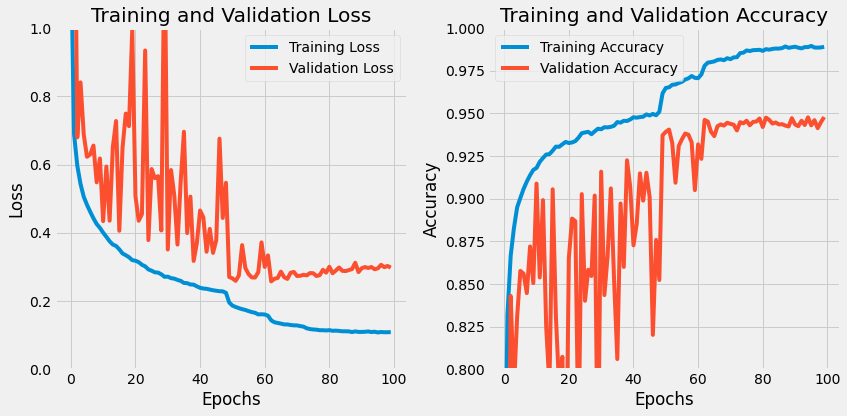

In [16]:
# Plot Learning Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

ax1.plot(hist.history['loss'], label='Training Loss')
ax1.plot(hist.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_ylim(bottom=0.0, top=1.0)
ax1.legend()

ax2.plot(hist.history['accuracy'], label='Training Accuracy')
ax2.plot(hist.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(top=1.0, bottom=0.8)
ax2.legend()

plt.show()

In [17]:
# Evaluating Training and Testing Set
train = resnet.evaluate(x_train, y_train)
test  = resnet.evaluate(x_test, y_test)

# Creating a Logger to store all Evaluation Results
logger = pd.DataFrame(columns=['Train Loss', 'Train Acc', 'Test Loss', 'Test Acc'])
logger = logger.append(
    pd.Series(
        {
            'Train Loss': train[0],
            'Train Acc' : train[1],
            'Test Loss' : test[0],
            'Test Acc'  : test[1],
            'Test Percentage Error': "{:.2%}".format(1.0 - test[1])
        },
        name='ResNet{}'.format(config.depth),))
logger

313/313 [==============================] - 4s 11ms/step - loss: 0.3216 - accuracy: 0.9392


,Train Loss,Train Acc,Test Loss,Test Acc,Test Percentage Error
ResNet32,0.133914,0.981967,0.321648,0.9392,6.08%


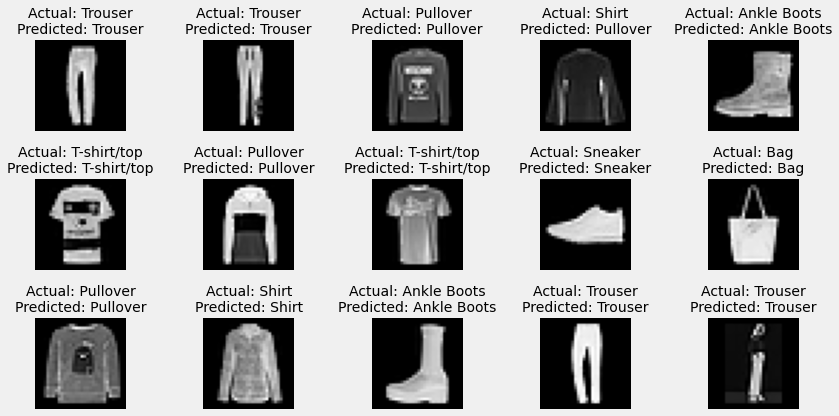

In [18]:
# Predict the values from the test dataset
y_pred = resnet.predict(x_test)
# Convert predictions classes to one hot encoded vectors 
y_pred_class = np.argmax(y_pred, axis = 1) 

w = 5
h = 3
fig = plt.figure(figsize=(12, 6), tight_layout=True)
for i in range(w*h):
  rand_idx = np.random.randint(0, len(x_test))
  ax = fig.add_subplot(h, w, i+1)
  ax.imshow((tf.reshape(x_test[rand_idx], (32, 32, 3)) + 1) / 2)
  ax.axis('off')
  ax.set_title(f'Actual: {classes[y_test[rand_idx]]}\nPredicted: {classes[y_pred_class[rand_idx]]}', fontsize=14)
plt.show()

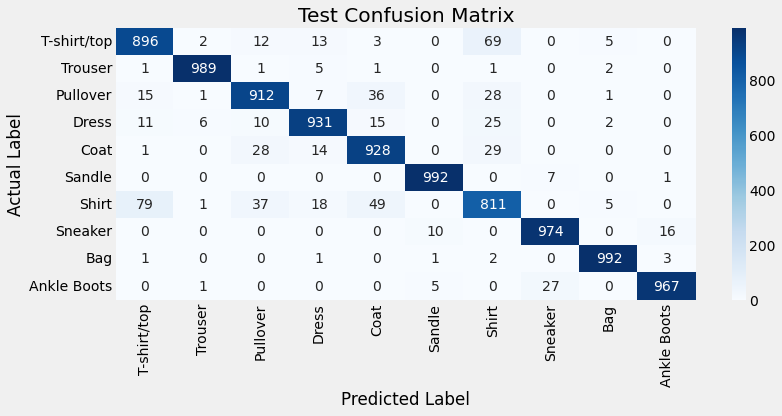

In [19]:
from sklearn.metrics import confusion_matrix
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_class)

sns.heatmap(confusion_mtx, cmap='Blues', annot=True, xticklabels=classes, yticklabels=classes, fmt='.3g')
plt.title('Test Confusion Matrix')
plt.xticks(rotation=90)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [20]:
from sklearn.metrics import classification_report
# print out classification report
print(classification_report(y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

 T-shirt/top       0.89      0.90      0.89      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.91      0.91      0.91      1000
       Dress       0.94      0.93      0.94      1000
        Coat       0.90      0.93      0.91      1000
      Sandle       0.98      0.99      0.99      1000
       Shirt       0.84      0.81      0.83      1000
     Sneaker       0.97      0.97      0.97      1000
         Bag       0.99      0.99      0.99      1000
 Ankle Boots       0.98      0.97      0.97      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



## Observations / Further Improvement

- ResNet performed very well, with a very high test accuracy of about 94%
- The network is able to generalise well to achieve 94% test accuracy
- However there are variance between training and validation accuracy, but I do not think it is necessary to include additional regularization

<br>

- I want to try expose the entire training set to various architectures network and see the performance of the train and test accuracy, as having more training data would slightly increase the model performance.


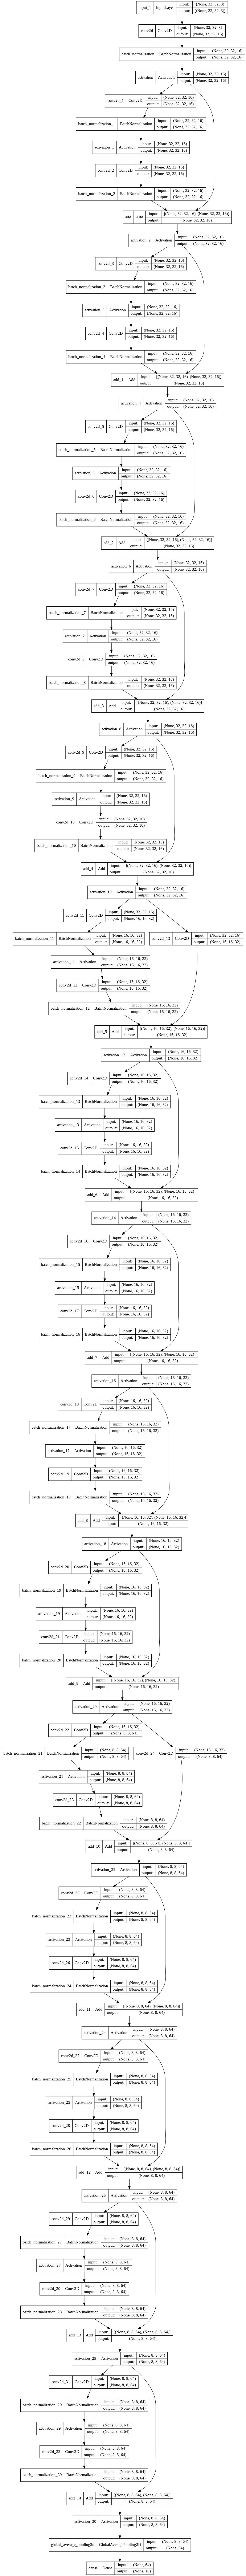

In [21]:
# display the entire
plot_model(resnet, show_shapes=True, expand_nested=True)